In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/만들면서 배우는 파이토치/예제 소스/5_gan_generation'

/content/drive/MyDrive/만들면서 배우는 파이토치/예제 소스/5_gan_generation


In [3]:
# 패키지 import
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [4]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

## Generator 구성

In [ ]:
!pip install torchsummary

In [ ]:
import torchsummary

In [6]:
class Generator(nn.Module):

    def __init__(self, z_dim=20,image_size=64):
        super(Generator,self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim,image_size*8,
                               kernel_size=4,stride=1),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True) # 메모리 아끼기 위해 inplace 옵션
                            
        )

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size*8,image_size*4,
                               kernel_size=4, stride=2,padding=1),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size*4,image_size*2,
                               kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(inplace=True)
        )

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size*2,image_size,
                               kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True)
        )

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size,1,
                               kernel_size=4, # 흑백이라 output channel=1
                               stride=2,padding=1),
            # nn.ReLU(inplace=True) # 왜 전까지 ReLU를 쓰다가 마지막에 하이퍼 탄젠트?
            nn.Tanh()
        )

    def forward(self,z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out

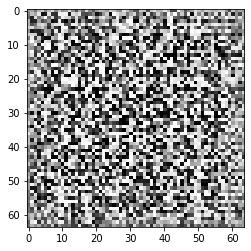

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20,image_size=64)

input_z = torch.randn(1,20) # 20개 1이 평균인 정규분포에서 나온 숫자들 추출
# torch.randn()
input_z = input_z.view(input_z.size(0),input_z.size(1),1,1)

fake_image = G(input_z)

image_transformed = (fake_image[0][0]).detach().numpy()
plt.imshow(image_transformed,'gray')
plt.show()

In [8]:
# torchsummary.summary(G,input_size=(20,1,1)) # 왜 image_size라는 표현을 사용했을까?...

In [9]:
class Discriminator(nn.Module):
    def __init__(self,z_dim=20,image_size=64):
        super(Discriminator,self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1,image_size,kernel_size=4,stride=2,padding=1),
            nn.LeakyReLU(0.1,inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size,image_size*2,kernel_size=4,
                      stride=2,padding=1),
            nn.LeakyReLU(0.1,inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2,image_size*4,kernel_size=4,
                      stride=2,padding=1),
            nn.LeakyReLU(0.1,inplace=True)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8,kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1,inplace=True)
        )

        self.last = nn.Conv2d(image_size*8,1,kernel_size=4,stride=2)

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

## Discriminator 구성

In [10]:
# 동작 확인
D = Discriminator(z_dim=20,image_size=64)

# 가짜 화상 생성
input_z = torch.randn(1,20)
input_z = input_z.view(input_z.size(0), input_z.size(1),1,1)
# input_z.cuda()
fake_images = G(input_z)
fake_images.shape # 1, 1, 64, 64

d_out = D(fake_images)
print(nn.Sigmoid()(d_out)) # 왜 d 자체에 안넣고 마지막에 모델 밖에서 시그모이드 처리를 해줄까?

tensor([[[[0.5066]]]], grad_fn=<SigmoidBackward0>)


In [11]:
# D 오차함수 이미지 구현
# max log(D(x)) + log(1-D(G(z)))

# 정답 라벨
mini_batch_size = 4
label_real = torch.full((mini_batch_size,),1)

# 가짜 라벨
label_fake = torch.full((mini_batch_size,),0)

# 오차함수 정의
criterion = nn.BCEWithLogitsLoss(reduction='mean')

# 진짜 화상 판정
d_out_real = D(x)

# 가짜 화상 생성하여 판정
input_z = torch.randn(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1),1,1)
fake_images = G(input_z)
d_out_fake = D(fake_images)

# 오차 계산
d_loss_real = criterion(d_out_real.view(-1), label_real)
d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
d_loss = d_loss_real + d_loss_fake

NameError: ignored

## 데이터 로더 작성

In [12]:
def make_datapath_list():
    """학습 화상데이터와 파일 레이블 리스트 작성 코드"""

    train_img_list = list()

    for img_idx in range(200):
        img_path = '/content/drive/MyDrive/만들면서 배우는 파이토치/예제 소스/5_gan_generation/data/img_78/img_7_'+str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = '/content/drive/MyDrive/만들면서 배우는 파이토치/예제 소스/5_gan_generation/data/img_78/img_8_'+str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list # 총 400개의 7,8,7,8 ... 이미지 경로 list 반환

class ImageTransform():
    """ mnist dataset 전처리 클래스 """
    def __init__(self,mean,std):
        self.data_transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean,std)
        ])

    def __call__(self,img):
        return self.data_transform(img)

class GAN_Img_Dataset(data.Dataset):
    """ 이미지의 데이터셋 클래스, 파이토치의 데이터셋 클래스 상속"""

    def __init__(self,file_list,transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        """ 화상의 개수 반환"""
        return len(self.file_list)

    def __getitem__(self,index):
        """ 전처리한 화상의 텐서 형식 데이터 취득"""

        img_path = self.file_list[index]
        img = Image.open(img_path)

        # 화상 전처리
        img_transformed = self.transform(img)

        return img_transformed

train_img_list=make_datapath_list()
mean=(0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list,transform=ImageTransform(mean,std)
)

# 데이터 로더 작성
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,batch_size=batch_size,shuffle=True
)

batch_iterator = iter(train_dataloader) # dataloader을 반복자로 전환해 batch 꺼낼 준비
images = next(batch_iterator)
print(images.size())

torch.Size([64, 1, 64, 64])


## DCGAN 학습

In [13]:
# 네트워크 초기화
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # ConvTranspose 2d레이어에 대해
        nn.init.normal_(m.weight.data,0.0,0.02) # 평균이 0, 표편이 0.02인 정규분포로 초기화
        nn.init.constant_(m.bias.data,0.)

    elif classname.find('BatchNorm') != -1:
        # batchnorm 레이어에 대해
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(m.bias.data,0)

# 초기화 실시
G.apply(weights_init)
D.apply(weights_init)

print('네트워트 초기화 완료')


네트워트 초기화 완료


In [14]:
# 모델을 학습시키는 함수 작성
def train_model(G,D,dataloader,num_epochs):
    # G, D 를 하나로 묶어서 훈련시킴.
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('사용장치:',device)

    # optimizer 설정
    g_lr,d_lr = 0.0001,0.0004
    beta1,beta2 = 0.0,0.9
    g_optimizer = torch.optim.Adam(G.parameters(),g_lr, [beta1,beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1,beta2])

    # 목적함수 정의
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    z_dim = 20
    mini_batch_size = 64

    # GPU로 올리기
    G.to(device)
    D.to(device)
    G.train()
    D.train()

    torch.backends.cudnn.benchmark = True

    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # 반복 카운트
    iteration=1
    logs=[]

    # 에폭
    for epoch in range(num_epochs):
        t_epoch_start = time.time()
        epoch_g_loss = 0.0 
        epoch_d_loss = 0.0

        print('--------'*5)
        print('Epoch {}/{}'.format(epoch,num_epochs))
        print('--------'*5)
        print(' (train) ')

        # 데이터 로더에서 배치 하나씩 꺼내기
        for imges in dataloader:
            ###############################
            # 1. D 학습
            # 미니 배치 크기가 1이면 배치정규화에서 오류가 발생한다.
            ###############################

            if imges.size()[0] == 1:
                continue

            imges = imges.to(device)

            # 정답 라벨과 가짜 라벨 작성
            # 맨 마지막 에폭은 배치 크기가 작음

            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,),1).to(device)
            label_fake = torch.full((mini_batch_size,),0).to(device)

            # 실제 화상 판정
            d_out_real = D(imges)

            # 가짜 화상 생성 후 판정
            input_z = torch.randn(mini_batch_size,z_dim).to(device)
            input_z = input_z.view(input_z.size(0),input_z.size(1),1,1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 오차 계산
            d_loss_real = criterion(d_out_real.view(-1),label_real.float())
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake.float())
            d_loss = d_loss_real + d_loss_fake

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            ###############################
            # 2. Generator 학습
            ###############################
            input_z = torch.randn(mini_batch_size,z_dim).to(device)
            input_z = input_z.view(input_z.size(0),input_z.size(1),1,1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)           

            # 오차 계산
            g_loss = criterion(d_out_fake.view(-1), label_real.float())

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            
            ###############################
            # 3. 기록
            ###############################
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # 에폭 phase별 loss와 정답률
        t_epoch_finish = time.time()
        print('####################')
        print('epoch {} || Epoch_D_Loss:{:.4f} || Epoch_G_Loss:{:.4f}'.format(epoch,epoch_d_loss/batch_size,epoch_g_loss/batch_size))
        print('timer: {:.4f} sec.'.format(t_epoch_finish-t_epoch_start)) 
        t_epoch_start = time.time()

    return G,D

In [ ]:
num_epoch = 200
G_update,D_update = train_model(G,D,dataloader=train_dataloader,num_epochs=num_epoch)

사용장치: cuda:0
#########################
Epoch 0/200
#########################
 (train) 
####################
epoch 0 || Epoch_D_Loss:0.0635 || Epoch_G_Loss:0.2357
timer: 0.8877 sec.
#########################
Epoch 1/200
#########################
 (train) 
####################
epoch 1 || Epoch_D_Loss:0.0073 || Epoch_G_Loss:0.6351
timer: 0.7756 sec.
#########################
Epoch 2/200
#########################
 (train) 
####################
epoch 2 || Epoch_D_Loss:0.2014 || Epoch_G_Loss:0.2216
timer: 0.7733 sec.
#########################
Epoch 3/200
#########################
 (train) 
####################
epoch 3 || Epoch_D_Loss:0.0095 || Epoch_G_Loss:0.3674
timer: 0.7654 sec.
#########################
Epoch 4/200
#########################
 (train) 
####################
epoch 4 || Epoch_D_Loss:0.0019 || Epoch_G_Loss:0.5184
timer: 0.7708 sec.
#########################
Epoch 5/200
#########################
 (train) 
####################
epoch 5 || Epoch_D_Loss:0.4174 || Epoch_G_Loss:0.561

## 학습결과 구현

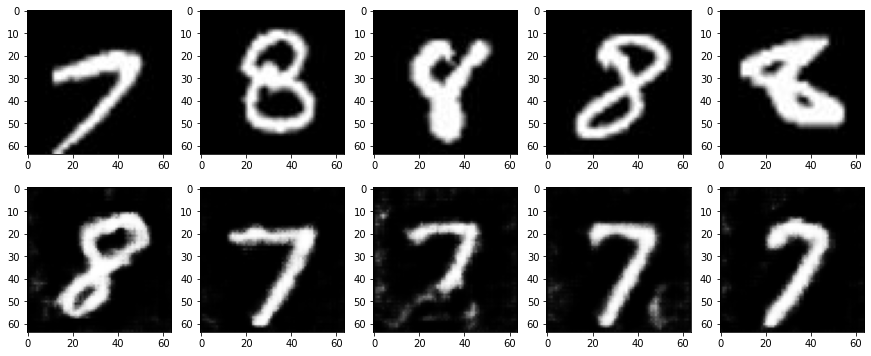

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

batch_size = 8

# 입력 난수 생성
z_dim = 20
fixed_z = torch.randn(batch_size,z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1),1,1) 

# 화상 생성
G_update.eval()
fake_images = G_update(fixed_z.to(device))

# 훈련 데이터
batch_iterator = iter(train_dataloader)
imges = next(batch_iterator)

# 출력
fig = plt.figure(figsize=(15,6))

for i in range(0,5):
    plt.subplot(2,5,i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(),'gray')

    plt.subplot(2,5,5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(),'gray')


## Self Attention GAN

In [15]:
class Self_Attention(nn.Module):
    """Self-Attention의 Layer"""

    def __init__(self, in_dim):
        super(Self_Attention, self).__init__()

        # 1×1의 합성곱 층에 의한 pointwise convolution를 준비
        self.query_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim, kernel_size=1)

        # Attention Map 작성시의 규격화의 소프트맥스
        self.softmax = nn.Softmax(dim=-2)

        # 원래 입력 x와 Self-Attention Map인 o를 더할 때의 계수
        # output = x +gamma*o
        # 처음에는 gamma=0으로 학습시킨다
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):

        # 입력 변수
        X = x

        # 합성곱한 뒤, 크기를 변형시킨다. B,C',W,H→B,C',N으로
        proj_query = self.query_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # 크기: B,C',N
        proj_query = proj_query.permute(0, 2, 1)  # 전치 조작
        proj_key = self.key_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # 크기: B,C',N

        # 곱셈
        S = torch.bmm(proj_query, proj_key)  # bmm은 배치별 행렬곱입니다

        # 규격화
        attention_map_T = self.softmax(S)  # i행 방향의 합을 1로 하는 소프트맥스 함수
        attention_map = attention_map_T.permute(0, 2, 1)  # 전치한다

        # Self-Attention Map을 계산한다
        proj_value = self.value_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # 크기: B,C,N
        o = torch.bmm(proj_value, attention_map.permute(
            0, 2, 1))  # Attention Map을 전치하여 곱함

        # Self-Attention Map o의 텐서 크기를 X로 준비하여 출력으로 한다
        o = o.view(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
        out = x+self.gamma*o

        return out, attention_map


# Generator 구현

In [16]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.ConvTranspose2d(z_dim, image_size * 8,
                                                      kernel_size=4, stride=1)),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 8, image_size * 4,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 4, image_size * 2,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        # Self-Attention층을 추가
        self.self_attntion1 = Self_Attention(in_dim=image_size * 2)

        self.layer4 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 2, image_size,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        # Self-Attention층을 추가
        self.self_attntion2 = Self_Attention(in_dim=image_size)

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
        # 주의: 흑백 화상이므로 출력 채널은 하나 뿐임


    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attntion1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attntion2(out)
        out = self.last(out)

        return out, attention_map1, attention_map2


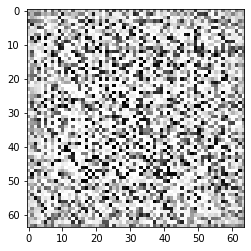

In [17]:
# 동작 확인
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

# 난수 입력
input_z = torch.randn(1, 20)

# 텐서 크기를 (1, 20, 1, 1)으로 변형
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 가짜 화상을 출력
fake_images, attention_map1, attention_map2 = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()


# Discriminator 구현

In [18]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.Conv2d(1, image_size, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))
        # 주의: 흑백 화상이므로 출력 채널은 하나 뿐임

        self.layer2 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.Conv2d(image_size, image_size*2, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        # Self-Attention층을 추가
        self.self_attntion1 = Self_Attention(in_dim=image_size*4)

        self.layer4 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        # Self-Attention층을 추가
        self.self_attntion2 = Self_Attention(in_dim=image_size*8)

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attntion1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attntion2(out)
        out = self.last(out)

        return out, attention_map1, attention_map2


In [43]:
# 동작 확인
D = Discriminator(z_dim=20, image_size=64)
D.to('cuda')
G.to('cuda')

# 가짜 화상 생성
for i in range(14):
    input_z = torch.randn(1, 20)
    input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1).to(device)
    fake_images, _, _ = G(input_z)

    # 가짜 화상을 D에 입력
    d_out, attention_map1, attention_map2 = D(fake_images)

    # 출력 d_out에 Sigmoid를 곱해 0에서 1로 변환
    print(d_out[0][0][0][0])


tensor(0.0028, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(-0.0073, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(-0.0081, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(-0.0020, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(-0.0049, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0026, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(-0.0114, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(-0.0029, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(-0.0204, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(-0.0115, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(-0.0039, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(-0.0113, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(-0.0056, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(-0.0032, device='cuda:0', grad_fn=<SelectBackward0>)


# DataLoader 작성

In [20]:
def make_datapath_list():
    """학습 및 검증 화상 데이터와 어노테이션 데이터의 파일 경로 리스트를 작성한다. """

    train_img_list = list()  # 화상 파일 경로를 저장

    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


In [21]:
class ImageTransform():
    """화상의 전처리 클래스"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)


In [22]:
class GAN_Img_Dataset(data.Dataset):
    """화상의 Dataset 클래스. PyTorch의 Dataset 클래스를 상속"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''화상 매수를 반환한다'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''전처리한 화상의 Tensor 형식 데이터 취득'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [높이][폭]흑백

        # 화상 전처리
        img_transformed = self.transform(img)

        return img_transformed


In [23]:
# DataLoader 작성과 동작 확인

# 파일 리스트를 작성
train_img_list=make_datapath_list()

# Dataset 작성
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoader 작성
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 동작 확인
batch_iterator = iter(train_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다
print(imges.size())  # torch.Size([64, 1, 64, 64])


torch.Size([64, 1, 64, 64])


# 학습시킨다

In [24]:
# 모델을 학습시키는 함수를 작성
def train_model(G, D, dataloader, num_epochs):

    # GPU가 사용 가능한지 확인
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용 장치: ", device)

    # 최적화 기법 설정
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 오차함수 정의 → hinge version of the adversarial loss로 변경
    # criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # 파라미터를 하드코딩
    z_dim = 20
    mini_batch_size = 64

    # 네트워크를 GPU로
    G.to(device)
    D.to(device)

    G.train()  # 모델을 훈련 모드로
    D.train()  # 모델을 훈련 모드로

    # 네트워크가 어느 정도 고정되면, 고속화시킨다
    torch.backends.cudnn.benchmark = True

    # 화상의 매수
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # 반복 카운터 설정
    iteration = 1
    logs = []

    # epoch 루프
    for epoch in range(num_epochs):

        # 개시 시간을 저장
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epoch의 손실합
        epoch_d_loss = 0.0  # epoch의 손실합

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('(train)')

        # 데이터 로더에서 minibatch씩 꺼내는 루프
        for imges in dataloader:

            # --------------------
            # 1. Discriminator 학습
            # --------------------
            # 미니 배치 크기가 1이면, 배치 노멀라이제이션에서 에러가 발생하므로 피한다
            if imges.size()[0] == 1:
                continue

            # GPU가 사용 가능하면 GPU로 데이터를 보낸다
            imges = imges.to(device)

            # 정답 라벨과 가짜 라벨 작성
            # epoch의 마지막 반복은 미니 배치 수가 줄어든다
            mini_batch_size = imges.size()[0]
            #label_real = torch.full((mini_batch_size,), 1).to(device)
            #label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 진짜 화상을 판정
            d_out_real, _, _ = D(imges)

            # 가짜 화상을 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)

            # 오차를 계산→hinge version of the adversarial loss로 변경
            # d_loss_real = criterion(d_out_real.view(-1), label_real)
            # d_loss_fake = criterion(d_out_fake.view(-1), label_fake)

            d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean() # 왜 1에서 d_out_real을 빼주는지?
            # 오차 d_out_real이 1이상에서 오차 0이 된다. d_out_real>1에서,
            # 1.0 - d_out_real가 음수이면 ReLU로 0으로 한다

            d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()
            # 오차 d_out_fake가 -1 이하이면 오차 0이 된다. d_out_fake<-1에서,
            # 1.0 + d_out_real가 음수이면 ReLU로 0으로 한다

            d_loss = d_loss_real + d_loss_fake

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generator 학습
            # --------------------
            # 가짜 화상을 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)

            # 오차를 계산→hinge version of the adversarial loss로 변경
            #g_loss = criterion(d_out_fake.view(-1), label_real)
            g_loss = - d_out_fake.mean()

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 기록
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epoch의 phase별 loss와 정답률
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    # print("총 반복 횟수: ", iteration)

    return G, D


In [25]:
# 네트워크 초기화
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2d과 ConvTranspose2d 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2d 초기화
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# 초기화 실시
G.apply(weights_init)
D.apply(weights_init)

print("네트워크 초기화 완료")


네트워크 초기화 완료


In [26]:
# 학습 및 검증을 실행한다
# 15분 정도 걸립니다
num_epochs = 300
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs)


사용 장치:  cuda:0
-------------
Epoch 0/300
-------------
(train)
-------------
epoch 0 || Epoch_D_Loss:0.1331 ||Epoch_G_Loss:0.0434
timer:  63.3991 sec.
-------------
Epoch 1/300
-------------
(train)
-------------
epoch 1 || Epoch_D_Loss:0.1238 ||Epoch_G_Loss:0.0273
timer:  1.3221 sec.
-------------
Epoch 2/300
-------------
(train)
-------------
epoch 2 || Epoch_D_Loss:0.1157 ||Epoch_G_Loss:0.0027
timer:  1.2732 sec.
-------------
Epoch 3/300
-------------
(train)
-------------
epoch 3 || Epoch_D_Loss:0.0951 ||Epoch_G_Loss:0.0597
timer:  1.3006 sec.
-------------
Epoch 4/300
-------------
(train)
-------------
epoch 4 || Epoch_D_Loss:0.1096 ||Epoch_G_Loss:0.0458
timer:  1.2939 sec.
-------------
Epoch 5/300
-------------
(train)
-------------
epoch 5 || Epoch_D_Loss:0.0656 ||Epoch_G_Loss:0.0859
timer:  1.2847 sec.
-------------
Epoch 6/300
-------------
(train)
-------------
epoch 6 || Epoch_D_Loss:0.0309 ||Epoch_G_Loss:0.1567
timer:  1.3114 sec.
-------------
Epoch 7/300
-------------

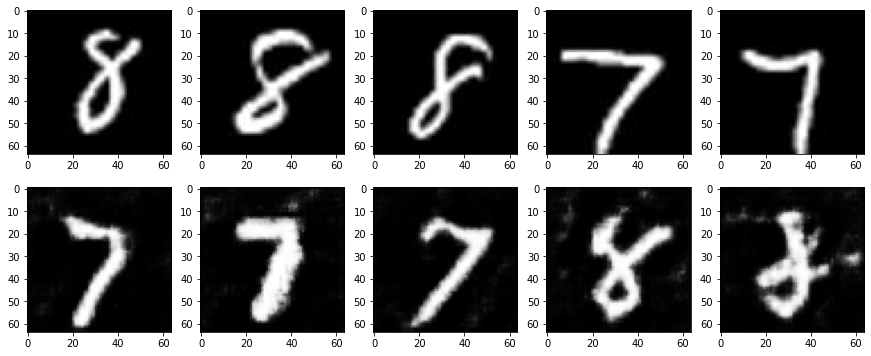

In [50]:
# 생성 화상과 훈련 데이터를 시각화한다
# 이 셀은 괜찮은 느낌의 화상이 생성될 때까지, 몇 번을 재실행하고 있습니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 입력 난수 생성
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 화상 생성
G_update.eval()
fake_images, am1, am2 = G_update(fixed_z.to(device))

# 훈련 데이터
batch_iterator = iter(train_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다


# 출력
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 상단에 훈련 데이터를,
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 하단에 생성 데이터를 표시한다
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')


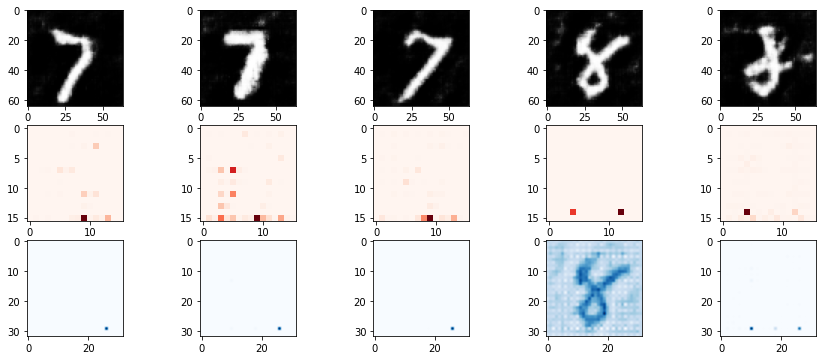

In [51]:
# Attentiom Map을 출력
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):

    # 상단에 생성한 화상 데이터를 표시
    plt.subplot(3, 5, i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

    # 하단에 Attention Map1 화상 중앙의 픽셀 데이터를 표시
    plt.subplot(3, 5, 5+i+1)
    am = am1[i].view(16, 16, 16, 16)
    am = am[7][7]  # 중앙에 주목
    plt.imshow(am.cpu().detach().numpy(), 'Reds')

    plt.subplot(3, 5, 10+i+1)
    am = am2[i].view(32, 32, 32, 32)
    am = am[15][15]  # 중앙에 주목
    plt.imshow(am.cpu().detach().numpy(), 'Blues')  
    


끝